## Comparison to De la Camera, (2014?) JGR
Looking at source level data, how do source level vorticity (at 350hPa) and surface precip look like? Are they log-normal/+vely skewed?
### GPCP Precipitation

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt

GPCP_PATH = '/oak/stanford/groups/aditis2/robcking/GPCP_2014/*.nc'
ds_gpcp = xr.open_mfdataset(GPCP_PATH)
ds_gpcp

<xarray.Dataset> Size: 96MB
Dimensions:      (time: 365, latitude: 180, nv: 2, longitude: 360)
Coordinates:
  * latitude     (latitude) float32 720B -90.0 -89.0 -88.0 ... 87.0 88.0 89.0
  * longitude    (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time         (time) datetime64[ns] 3kB 2014-01-01 2014-01-02 ... 2014-12-31
Dimensions without coordinates: nv
Data variables:
    lat_bounds   (time, latitude, nv) float32 526kB dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    lon_bounds   (time, longitude, nv) float32 1MB dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    time_bounds  (time, nv) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip       (time, latitude, longitude) float32 95MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     /data1/GPCP_CDR/GPCP_Output/1DD//bin/201401/s...
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) 2017-05-30T17:14:39Z, Dr. Jian-Jian Wang, ...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:XXXXX
    product_version:            v01r03
    platform:                   GOES (Geostationary Operational Environmental...
    sensor:                     Imager, AIRS > Atmospheric Infrared Sounder, ...
    spatial_resolution:         1 degree
    comment:                    Processing computer: eagle2.umd.edu

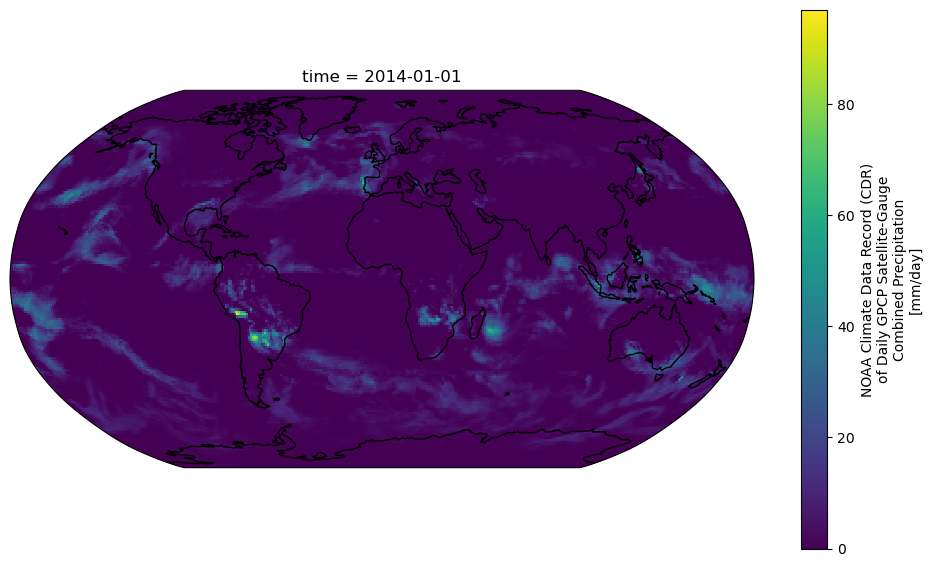

In [2]:
fig = plt.figure(figsize=(12,7))
ax = plt.axes(projection=ccrs.Robinson())
ds_gpcp.isel(time=0).precip.plot.pcolormesh(ax=ax,x='longitude',y='latitude',transform=ccrs.PlateCarree())
ax.coastlines()

In [3]:
from ad99py.masks import mask_dataset

DATADIR = '../../data'
ds_gpcp_masked = mask_dataset(ds_gpcp,dir=DATADIR,basins=['southern_ocean'])

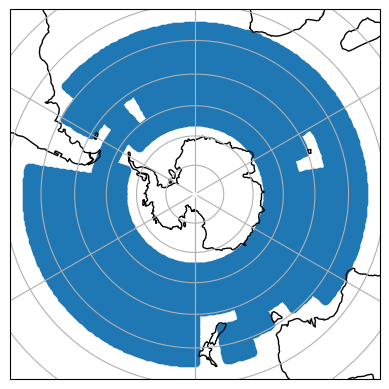

In [4]:
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.scatter(ds_gpcp_masked.longitude,ds_gpcp_masked.latitude,transform=ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()

In [5]:
precip_samples = ds_gpcp_masked.precip.data.ravel().compute()
nonzero_precip_sq = precip_samples[precip_samples > 0]**2

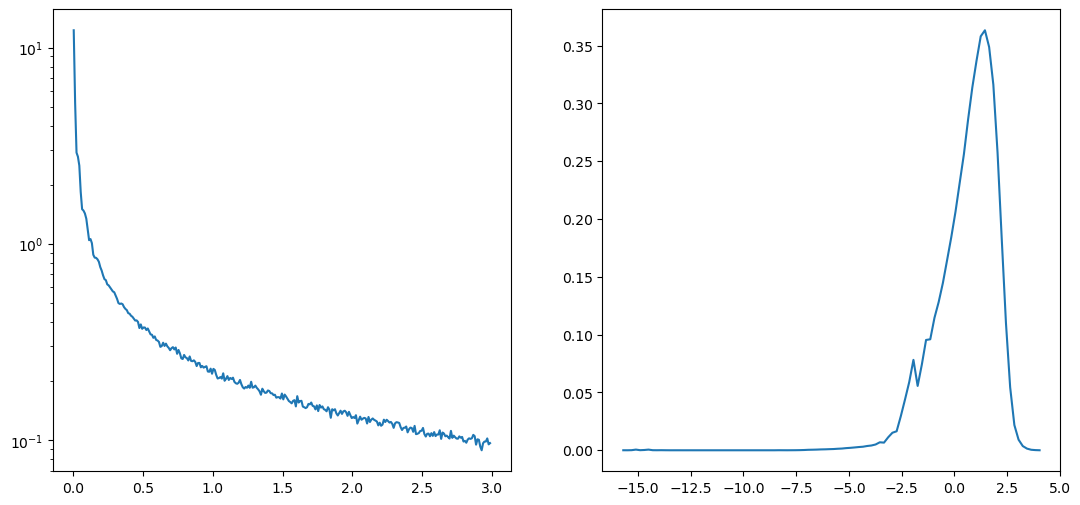

In [41]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
bins_norm = np.arange(0,3,0.01)

precip_hist,_= np.histogram(nonzero_precip_sq,bins=bins_norm,density=True)
bins_norm_c = 0.5*(bins_norm[1:] + bins_norm[:-1])
logprecip_hist,bins_log = np.histogram(np.log10(nonzero_precip_sq),bins=100,density=True)
bins_log_g = 0.5*(bins_log[1:] + bins_log[:-1])
ax1.plot(bins_norm_c,precip_hist)
ax1.set_yscale('log')
ax2.plot(bins_log_g,logprecip_hist)

## ERA5 (relative vorticity squared)

In [22]:
ds_era5 = xr.open_dataset('/oak/stanford/groups/aditis2/robcking/era5_vorticity.grib')
ds_era5 = mask_dataset(ds_era5,dir=DATADIR)

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [26]:
ds_era5

<xarray.Dataset> Size: 4GB
Dimensions:        (time: 1460, isobaricInhPa: 2, points: 324800)
Coordinates:
    number         int64 8B 0
  * time           (time) datetime64[ns] 12kB 2014-01-01 ... 2014-12-31T18:00:00
    step           timedelta64[ns] 8B 00:00:00
  * isobaricInhPa  (isobaricInhPa) float64 16B 500.0 350.0
    valid_time     (time) datetime64[ns] 12kB ...
    latitude       (points) float64 3MB 49.75 49.75 49.75 ... -65.0 -65.0 -65.0
    longitude      (points) float64 3MB 150.0 150.2 150.5 ... 359.2 359.5 359.8
Dimensions without coordinates: points
Data variables:
    vo             (time, isobaricInhPa, points) float32 4GB -1.864e-06 ... 0...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-11T14:24 GRIB to CDM+CF via cfgrib-0.9.1...

In [37]:
vo= ds_era5.sel(isobaricInhPa=350.0).vo.data.ravel()
vo2 = vo**2
vo2 = vo2[vo2>0]


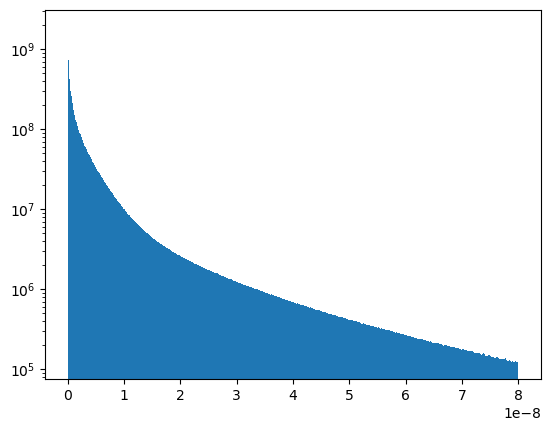

In [38]:
x = np.arange(0,8.01e-8,0.01*1e-8)
_ = plt.hist(vo2,bins=x,density=True)
plt.yscale('log')

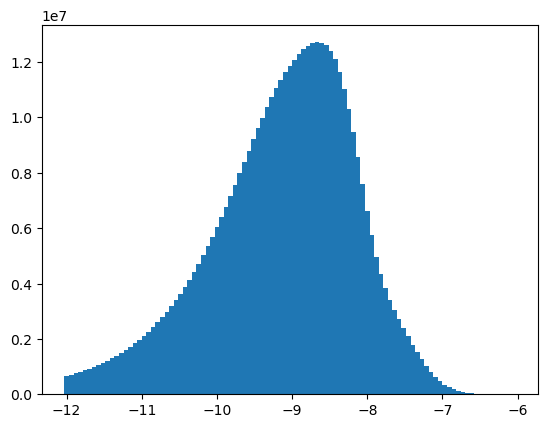

In [40]:
x = np.linspace(np.median(np.log10(vo2)) -3,np.median(np.log10(vo2))+3,100)
_= plt.hist(np.log10(vo2),bins=x)